# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [30]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [32]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [33]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [34]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform = transforms.Compose([transforms.Resize(image_size), # resize to image_size
                                    transforms.ToTensor()])
    image_path = './' + data_dir
    train_dataset = datasets.ImageFolder(image_path, transform)
    # TODO: Implement function and return a dataloader
    data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return data_loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [37]:
# Define function hyperparameters
batch_size = 24
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

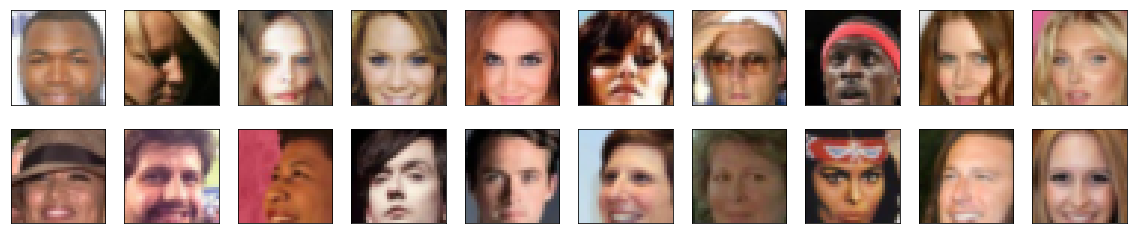

In [38]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [39]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = 2*x-1
    return x


In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.6235)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [41]:
import torch.nn as nn
import torch.nn.functional as F

In [42]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [43]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator ModuleD.parameters()[1]
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv1 = conv(3,conv_dim,4,batch_norm=False)
        self.conv2 = conv(conv_dim,conv_dim*2,4)
        self.conv3 = conv(conv_dim*2,conv_dim*4,4)
        self.conv4 = conv(conv_dim*4,1,4,stride=1,padding=0,batch_norm=False)
   
        self.Relu  = nn.ReLU(inplace=True)
        self.drop  = nn.Dropout(0.2)

        # complete init function
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
    
        out = self.Relu(self.conv1(x))
        out = self.drop(out)
        out = self.Relu(self.conv2(out))
        out = self.drop(out)
        out = self.Relu(self.conv3(out))
        out = self.drop(out)
        out = (self.conv4(out))
        out = out.view(out.size(0),-1)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [44]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [45]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim=conv_dim
        self.fc1 = nn.Linear(z_size, 16*conv_dim*16)
        self.deconv1 =deconv(16*conv_dim,8*conv_dim,4,batch_norm=False)
        
        self.deconv2 =deconv(8*conv_dim,4*conv_dim,4,batch_norm=True)
        self.deconv3 =deconv(4*conv_dim,3,4,batch_norm=True)

        self.Relu = nn.ReLU(inplace=True) 
        self.drop  = nn.Dropout(0.2)
        # complete init function
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
  
        out= self.fc1(x)
        out =self.drop(out)
        out = out.view(-1,self.conv_dim*16,4,4)
       
        out =self.drop(out)
        out= self.Relu(self.deconv1(out))
        
        out =self.drop(out)
        out= self.Relu(self.deconv2(out))
       
        out =self.drop(out) 
        out= (self.deconv3(out))
        out = F.tanh(out)
      
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/home/tapanbhavsar/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [46]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.xavier_normal_(m.weight.data)
        
            
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [47]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    
    return D, G


#### Exercise: Define model hyperparameters

In [48]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (Relu): ReLU(inplace)
  (drop): Dropout(p=0.2)
)

Generator(
  (fc1): Linear(in_features=100, out_features=8192, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bi

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [78]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
 
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*np.random.uniform(0.7,1.2)
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
  
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)*np.random.uniform(0,0.3) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [79]:
import torch.optim as optim


# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr =0.0002, betas=(0.15 ,.999))
g_optimizer = optim.Adam(G.parameters(), lr =0.0002, betas=(0.15 ,.999))

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [80]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    G.train()
    D.train()
    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            if train_on_gpu:
                real_images=real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            d_optimizer.zero_grad()
           
            # 1. Train the discriminator on real and fake images
            out_D_real = D(real_images)
            
            d_real_loss = real_loss(out_D_real)
          
            fake_images = np.random.uniform(-1, 1, size=(batch_size, z_size))
            fake_images = torch.from_numpy(fake_images).float()
          
            if train_on_gpu:
                fake_images =fake_images.cuda()
        
            fake_images_D = G(fake_images)
         
            out_D_fake = D(fake_images_D)
           
            d_fake_loss = fake_loss(out_D_fake)
            
            d_loss = d_real_loss+ d_fake_loss
            d_loss.backward()
            
            d_optimizer.step()
            
            
             
            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            fake_images = np.random.uniform(-1, 1, size=(batch_size, z_size))
            fake_images = torch.from_numpy(fake_images).float()
            if train_on_gpu:
                fake_images =fake_images.cuda()
            
            g_out = G(fake_images)
            g_out = D(g_out)
            g_loss = real_loss(g_out)
            
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [81]:
# set number of epochs 
n_epochs = 30

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

/home/tapanbhavsar/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   30] | d_loss: 0.8713 | g_loss: 1.9146
Epoch [    1/   30] | d_loss: 0.1602 | g_loss: 4.3946
Epoch [    1/   30] | d_loss: 0.7291 | g_loss: 2.5516
Epoch [    1/   30] | d_loss: 0.3060 | g_loss: 4.1078
Epoch [    1/   30] | d_loss: 0.1763 | g_loss: 1.8891
Epoch [    1/   30] | d_loss: 0.1107 | g_loss: 4.2882
Epoch [    1/   30] | d_loss: 0.3386 | g_loss: 3.8431
Epoch [    1/   30] | d_loss: 0.4212 | g_loss: 1.5052
Epoch [    1/   30] | d_loss: 1.7194 | g_loss: 2.3726
Epoch [    1/   30] | d_loss: 0.2850 | g_loss: 3.5580
Epoch [    1/   30] | d_loss: 0.6875 | g_loss: 2.3459
Epoch [    1/   30] | d_loss: 0.4325 | g_loss: 2.6859
Epoch [    1/   30] | d_loss: 0.8317 | g_loss: 1.8132
Epoch [    1/   30] | d_loss: 0.2793 | g_loss: 4.3791
Epoch [    1/   30] | d_loss: 0.3250 | g_loss: 3.4996
Epoch [    1/   30] | d_loss: 0.2795 | g_loss: 2.8018
Epoch [    1/   30] | d_loss: 0.3212 | g_loss: 3.3440
Epoch [    1/   30] | d_loss: 0.0810 | g_loss: 1.6864
Epoch [    1/   30] | d_loss

Epoch [    3/   30] | d_loss: 0.0615 | g_loss: 3.6745
Epoch [    3/   30] | d_loss: 0.8803 | g_loss: 4.0391
Epoch [    3/   30] | d_loss: 0.1306 | g_loss: 4.1629
Epoch [    3/   30] | d_loss: 0.9243 | g_loss: 3.1620
Epoch [    3/   30] | d_loss: 0.2205 | g_loss: 3.9527
Epoch [    3/   30] | d_loss: 1.5350 | g_loss: 6.2612
Epoch [    3/   30] | d_loss: 0.1578 | g_loss: 1.8891
Epoch [    3/   30] | d_loss: 1.1404 | g_loss: 0.6167
Epoch [    3/   30] | d_loss: 2.4407 | g_loss: 2.2255
Epoch [    3/   30] | d_loss: 0.3496 | g_loss: 2.8548
Epoch [    3/   30] | d_loss: 0.1521 | g_loss: 1.8557
Epoch [    3/   30] | d_loss: 1.1455 | g_loss: 2.1628
Epoch [    3/   30] | d_loss: 1.3416 | g_loss: 1.7830
Epoch [    3/   30] | d_loss: 1.0620 | g_loss: 2.7662
Epoch [    3/   30] | d_loss: 0.4841 | g_loss: 4.5457
Epoch [    3/   30] | d_loss: 0.5166 | g_loss: 2.5923
Epoch [    3/   30] | d_loss: 0.2237 | g_loss: 0.6837
Epoch [    3/   30] | d_loss: 0.1477 | g_loss: 1.4421
Epoch [    3/   30] | d_loss

Epoch [    5/   30] | d_loss: 1.9954 | g_loss: 2.8590
Epoch [    5/   30] | d_loss: 1.1671 | g_loss: 3.2257
Epoch [    5/   30] | d_loss: 0.2001 | g_loss: 1.9241
Epoch [    5/   30] | d_loss: 0.2647 | g_loss: 1.2001
Epoch [    5/   30] | d_loss: 0.7009 | g_loss: 3.9825
Epoch [    5/   30] | d_loss: 0.1416 | g_loss: 3.9979
Epoch [    5/   30] | d_loss: 0.6654 | g_loss: 2.2205
Epoch [    5/   30] | d_loss: 0.3837 | g_loss: 3.3181
Epoch [    5/   30] | d_loss: 0.3381 | g_loss: 4.4453
Epoch [    5/   30] | d_loss: 0.0881 | g_loss: 2.2426
Epoch [    5/   30] | d_loss: 0.6934 | g_loss: 3.5415
Epoch [    5/   30] | d_loss: 0.4923 | g_loss: 3.8659
Epoch [    5/   30] | d_loss: 0.8200 | g_loss: 3.2509
Epoch [    5/   30] | d_loss: 0.0777 | g_loss: 4.9018
Epoch [    5/   30] | d_loss: 0.5192 | g_loss: 2.8850
Epoch [    5/   30] | d_loss: 0.2002 | g_loss: 3.3694
Epoch [    5/   30] | d_loss: 0.2650 | g_loss: 3.2725
Epoch [    5/   30] | d_loss: 0.5739 | g_loss: 3.1590
Epoch [    5/   30] | d_loss

Epoch [    7/   30] | d_loss: 0.2058 | g_loss: 3.0692
Epoch [    7/   30] | d_loss: 0.4632 | g_loss: 1.3664
Epoch [    7/   30] | d_loss: 0.3892 | g_loss: 2.3951
Epoch [    7/   30] | d_loss: 0.7072 | g_loss: 2.3422
Epoch [    7/   30] | d_loss: 0.7892 | g_loss: 2.0710
Epoch [    7/   30] | d_loss: 0.0857 | g_loss: 5.4492
Epoch [    7/   30] | d_loss: 0.1225 | g_loss: 3.6161
Epoch [    7/   30] | d_loss: 0.6410 | g_loss: 1.2158
Epoch [    7/   30] | d_loss: 0.1542 | g_loss: 1.9221
Epoch [    7/   30] | d_loss: 0.8349 | g_loss: 2.7934
Epoch [    7/   30] | d_loss: 0.3092 | g_loss: 4.3911
Epoch [    7/   30] | d_loss: 0.1271 | g_loss: 2.6423
Epoch [    7/   30] | d_loss: 1.4137 | g_loss: 1.2574
Epoch [    7/   30] | d_loss: 2.0481 | g_loss: 1.0499
Epoch [    7/   30] | d_loss: 1.9340 | g_loss: 1.7193
Epoch [    7/   30] | d_loss: 1.1956 | g_loss: 3.1412
Epoch [    7/   30] | d_loss: 0.7510 | g_loss: 3.3359
Epoch [    7/   30] | d_loss: 0.1632 | g_loss: 1.2402
Epoch [    7/   30] | d_loss

Epoch [    9/   30] | d_loss: 0.6308 | g_loss: 4.1314
Epoch [    9/   30] | d_loss: 0.1993 | g_loss: 5.2855
Epoch [    9/   30] | d_loss: 1.4040 | g_loss: 0.2557
Epoch [    9/   30] | d_loss: 0.2948 | g_loss: 2.2805
Epoch [    9/   30] | d_loss: 0.9024 | g_loss: 4.2973
Epoch [    9/   30] | d_loss: 0.3134 | g_loss: 1.8959
Epoch [    9/   30] | d_loss: 0.4637 | g_loss: 2.1997
Epoch [    9/   30] | d_loss: 0.4369 | g_loss: 4.0720
Epoch [    9/   30] | d_loss: 0.4580 | g_loss: 4.4271
Epoch [    9/   30] | d_loss: 0.0151 | g_loss: 3.1912
Epoch [    9/   30] | d_loss: 0.1469 | g_loss: 2.6093
Epoch [    9/   30] | d_loss: 0.3526 | g_loss: 4.8814
Epoch [    9/   30] | d_loss: 0.5767 | g_loss: 2.1996
Epoch [    9/   30] | d_loss: 0.1210 | g_loss: 2.7967
Epoch [    9/   30] | d_loss: 0.3161 | g_loss: 2.9116
Epoch [    9/   30] | d_loss: 0.4551 | g_loss: 2.7293
Epoch [    9/   30] | d_loss: 0.7766 | g_loss: 3.6007
Epoch [    9/   30] | d_loss: 0.7613 | g_loss: 4.7093
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 1.0584 | g_loss: 1.1240
Epoch [   11/   30] | d_loss: 0.5131 | g_loss: 3.3141
Epoch [   11/   30] | d_loss: 1.3539 | g_loss: 3.0192
Epoch [   11/   30] | d_loss: 0.6025 | g_loss: 2.4723
Epoch [   11/   30] | d_loss: 0.1103 | g_loss: 5.0957
Epoch [   11/   30] | d_loss: 0.2100 | g_loss: 4.4011
Epoch [   11/   30] | d_loss: 0.3645 | g_loss: 4.3355
Epoch [   11/   30] | d_loss: 0.8287 | g_loss: 2.8299
Epoch [   11/   30] | d_loss: 0.3110 | g_loss: 5.7651
Epoch [   11/   30] | d_loss: 0.2035 | g_loss: 1.8268
Epoch [   11/   30] | d_loss: 0.5492 | g_loss: 2.5596
Epoch [   11/   30] | d_loss: 0.3149 | g_loss: 3.2435
Epoch [   11/   30] | d_loss: 0.3183 | g_loss: 6.0394
Epoch [   11/   30] | d_loss: 0.0527 | g_loss: 6.2877
Epoch [   11/   30] | d_loss: 0.1333 | g_loss: 4.1962
Epoch [   11/   30] | d_loss: 0.0620 | g_loss: 3.1975
Epoch [   11/   30] | d_loss: 0.6774 | g_loss: 3.8201
Epoch [   11/   30] | d_loss: 0.0791 | g_loss: 6.8815
Epoch [   11/   30] | d_loss

Epoch [   13/   30] | d_loss: 0.2759 | g_loss: 1.7653
Epoch [   13/   30] | d_loss: 0.2896 | g_loss: 4.9818
Epoch [   13/   30] | d_loss: 2.1536 | g_loss: 2.9893
Epoch [   13/   30] | d_loss: 0.2716 | g_loss: 4.1692
Epoch [   13/   30] | d_loss: 0.1178 | g_loss: 5.4050
Epoch [   13/   30] | d_loss: 0.2903 | g_loss: 4.9755
Epoch [   13/   30] | d_loss: 0.1521 | g_loss: 3.7786
Epoch [   13/   30] | d_loss: 0.1507 | g_loss: 1.1160
Epoch [   13/   30] | d_loss: 0.1286 | g_loss: 5.8920
Epoch [   13/   30] | d_loss: 0.0867 | g_loss: 3.2274
Epoch [   13/   30] | d_loss: 0.0939 | g_loss: 5.1504
Epoch [   13/   30] | d_loss: 0.7933 | g_loss: 3.7915
Epoch [   13/   30] | d_loss: 0.3462 | g_loss: 0.9460
Epoch [   13/   30] | d_loss: 0.4726 | g_loss: 2.6019
Epoch [   13/   30] | d_loss: 0.1998 | g_loss: 4.1715
Epoch [   13/   30] | d_loss: 0.0608 | g_loss: 2.4128
Epoch [   13/   30] | d_loss: 0.1470 | g_loss: 4.1019
Epoch [   13/   30] | d_loss: 0.0535 | g_loss: 2.7758
Epoch [   13/   30] | d_loss

Epoch [   15/   30] | d_loss: 0.2369 | g_loss: 4.5884
Epoch [   15/   30] | d_loss: 0.1906 | g_loss: 5.4534
Epoch [   15/   30] | d_loss: 0.4101 | g_loss: 3.4384
Epoch [   15/   30] | d_loss: 0.4048 | g_loss: 4.2715
Epoch [   15/   30] | d_loss: 0.1115 | g_loss: 4.7821
Epoch [   15/   30] | d_loss: 0.0796 | g_loss: 2.8013
Epoch [   15/   30] | d_loss: 0.2379 | g_loss: 5.7274
Epoch [   15/   30] | d_loss: 0.1407 | g_loss: 3.7495
Epoch [   15/   30] | d_loss: 0.7774 | g_loss: 3.3866
Epoch [   15/   30] | d_loss: 0.0733 | g_loss: 2.8966
Epoch [   15/   30] | d_loss: 0.1447 | g_loss: 4.6521
Epoch [   15/   30] | d_loss: 0.9615 | g_loss: 2.5121
Epoch [   15/   30] | d_loss: 0.1089 | g_loss: 3.7730
Epoch [   15/   30] | d_loss: 0.1521 | g_loss: 2.5446
Epoch [   15/   30] | d_loss: 0.1304 | g_loss: 1.2681
Epoch [   15/   30] | d_loss: 0.3983 | g_loss: 3.7697
Epoch [   15/   30] | d_loss: 0.3264 | g_loss: 2.9061
Epoch [   15/   30] | d_loss: 0.4174 | g_loss: 3.9498
Epoch [   15/   30] | d_loss

Epoch [   17/   30] | d_loss: 0.5501 | g_loss: 2.8286
Epoch [   17/   30] | d_loss: 1.1232 | g_loss: 2.9095
Epoch [   17/   30] | d_loss: 0.1073 | g_loss: 3.5123
Epoch [   17/   30] | d_loss: 0.2140 | g_loss: 2.5787
Epoch [   17/   30] | d_loss: 0.6495 | g_loss: 3.9920
Epoch [   17/   30] | d_loss: 0.4988 | g_loss: 3.1866
Epoch [   17/   30] | d_loss: 0.3014 | g_loss: 3.9524
Epoch [   17/   30] | d_loss: 1.3132 | g_loss: 3.6637
Epoch [   17/   30] | d_loss: 0.6125 | g_loss: 2.2572
Epoch [   17/   30] | d_loss: 0.0280 | g_loss: 4.7023
Epoch [   17/   30] | d_loss: 0.3996 | g_loss: 1.2527
Epoch [   17/   30] | d_loss: 0.4981 | g_loss: 1.4843
Epoch [   17/   30] | d_loss: 0.2641 | g_loss: 3.2138
Epoch [   17/   30] | d_loss: 0.2155 | g_loss: 4.0914
Epoch [   17/   30] | d_loss: 0.3548 | g_loss: 3.5006
Epoch [   17/   30] | d_loss: 0.1901 | g_loss: 3.0406
Epoch [   17/   30] | d_loss: 0.2464 | g_loss: 2.9600
Epoch [   17/   30] | d_loss: 0.3573 | g_loss: 1.2689
Epoch [   17/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.2158 | g_loss: 7.2329
Epoch [   19/   30] | d_loss: 1.1466 | g_loss: 5.3482
Epoch [   19/   30] | d_loss: 0.2529 | g_loss: 3.9915
Epoch [   19/   30] | d_loss: 0.2622 | g_loss: 1.1914
Epoch [   19/   30] | d_loss: 0.4544 | g_loss: 3.0364
Epoch [   19/   30] | d_loss: 0.1503 | g_loss: 3.9470
Epoch [   19/   30] | d_loss: 0.6607 | g_loss: 2.2444
Epoch [   19/   30] | d_loss: 0.1942 | g_loss: 2.9531
Epoch [   19/   30] | d_loss: 0.1386 | g_loss: 4.4651
Epoch [   19/   30] | d_loss: 0.4258 | g_loss: 2.4614
Epoch [   19/   30] | d_loss: 0.2115 | g_loss: 5.0194
Epoch [   19/   30] | d_loss: 0.8203 | g_loss: 3.2636
Epoch [   19/   30] | d_loss: 0.7152 | g_loss: 0.9922
Epoch [   19/   30] | d_loss: 0.0546 | g_loss: 2.9108
Epoch [   19/   30] | d_loss: 1.8512 | g_loss: 4.4233
Epoch [   19/   30] | d_loss: 1.1768 | g_loss: 2.5286
Epoch [   19/   30] | d_loss: 0.3214 | g_loss: 3.0243
Epoch [   19/   30] | d_loss: 0.2846 | g_loss: 2.8710
Epoch [   19/   30] | d_loss

Epoch [   21/   30] | d_loss: 0.0144 | g_loss: 4.2090
Epoch [   21/   30] | d_loss: 0.0933 | g_loss: 6.1555
Epoch [   21/   30] | d_loss: 0.5081 | g_loss: 6.0121
Epoch [   21/   30] | d_loss: 0.0410 | g_loss: 2.6033
Epoch [   21/   30] | d_loss: 0.1519 | g_loss: 4.6941
Epoch [   21/   30] | d_loss: 0.4747 | g_loss: 0.1112
Epoch [   21/   30] | d_loss: 0.2302 | g_loss: 2.8225
Epoch [   21/   30] | d_loss: 0.1535 | g_loss: 3.0382
Epoch [   21/   30] | d_loss: 0.0550 | g_loss: 3.5181
Epoch [   21/   30] | d_loss: 0.4453 | g_loss: 1.9123
Epoch [   21/   30] | d_loss: 0.6732 | g_loss: 6.8186
Epoch [   21/   30] | d_loss: 0.1168 | g_loss: 4.0565
Epoch [   21/   30] | d_loss: 0.3208 | g_loss: 1.3373
Epoch [   21/   30] | d_loss: 0.9395 | g_loss: 5.2676
Epoch [   21/   30] | d_loss: 0.0576 | g_loss: 4.6914
Epoch [   21/   30] | d_loss: 0.2039 | g_loss: 2.6938
Epoch [   21/   30] | d_loss: 0.0242 | g_loss: 5.5641
Epoch [   21/   30] | d_loss: 0.2201 | g_loss: 3.6594
Epoch [   21/   30] | d_loss

Epoch [   23/   30] | d_loss: 0.2804 | g_loss: 3.6322
Epoch [   23/   30] | d_loss: 0.3083 | g_loss: 4.3250
Epoch [   23/   30] | d_loss: 0.0901 | g_loss: 3.3276
Epoch [   23/   30] | d_loss: 0.7214 | g_loss: 1.7188
Epoch [   23/   30] | d_loss: 0.3230 | g_loss: 3.6022
Epoch [   23/   30] | d_loss: 0.1733 | g_loss: 5.5877
Epoch [   23/   30] | d_loss: 1.8023 | g_loss: 1.6843
Epoch [   23/   30] | d_loss: 1.0731 | g_loss: 1.5432
Epoch [   23/   30] | d_loss: 0.1120 | g_loss: 2.6807
Epoch [   23/   30] | d_loss: 0.1637 | g_loss: 5.1177
Epoch [   23/   30] | d_loss: 0.0706 | g_loss: 4.0977
Epoch [   23/   30] | d_loss: 0.1922 | g_loss: 0.9883
Epoch [   23/   30] | d_loss: 0.6965 | g_loss: 2.4328
Epoch [   23/   30] | d_loss: 0.2366 | g_loss: 3.2875
Epoch [   23/   30] | d_loss: 0.7730 | g_loss: 2.9590
Epoch [   23/   30] | d_loss: 0.0594 | g_loss: 2.1282
Epoch [   23/   30] | d_loss: 0.2146 | g_loss: 4.8418
Epoch [   23/   30] | d_loss: 0.1940 | g_loss: 4.8787
Epoch [   23/   30] | d_loss

Epoch [   25/   30] | d_loss: 0.0177 | g_loss: 2.9331
Epoch [   25/   30] | d_loss: 1.7692 | g_loss: 2.1810
Epoch [   25/   30] | d_loss: 0.1781 | g_loss: 3.4045
Epoch [   25/   30] | d_loss: 0.2048 | g_loss: 3.1890
Epoch [   25/   30] | d_loss: 0.8158 | g_loss: 3.3842
Epoch [   25/   30] | d_loss: 0.7008 | g_loss: 2.5202
Epoch [   25/   30] | d_loss: 1.3877 | g_loss: 3.2917
Epoch [   25/   30] | d_loss: 0.1981 | g_loss: 3.4411
Epoch [   25/   30] | d_loss: 0.0378 | g_loss: 2.0052
Epoch [   25/   30] | d_loss: 0.0211 | g_loss: 4.0930
Epoch [   25/   30] | d_loss: 0.4147 | g_loss: 2.6980
Epoch [   25/   30] | d_loss: 0.0422 | g_loss: 4.4932
Epoch [   25/   30] | d_loss: 0.0427 | g_loss: 3.8144
Epoch [   25/   30] | d_loss: 0.3104 | g_loss: 5.1272
Epoch [   25/   30] | d_loss: 0.3874 | g_loss: 3.7533
Epoch [   25/   30] | d_loss: 0.7162 | g_loss: 1.5092
Epoch [   25/   30] | d_loss: 0.7979 | g_loss: 3.6355
Epoch [   25/   30] | d_loss: 0.4164 | g_loss: 3.7973
Epoch [   25/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.1773 | g_loss: 3.5410
Epoch [   27/   30] | d_loss: 0.8650 | g_loss: 0.5576
Epoch [   27/   30] | d_loss: 0.0980 | g_loss: 4.4665
Epoch [   27/   30] | d_loss: 0.8921 | g_loss: 2.2041
Epoch [   27/   30] | d_loss: 0.2157 | g_loss: 3.4415
Epoch [   27/   30] | d_loss: 0.0950 | g_loss: 5.1050
Epoch [   27/   30] | d_loss: 0.3356 | g_loss: 1.9490
Epoch [   27/   30] | d_loss: 0.0873 | g_loss: 4.1618
Epoch [   27/   30] | d_loss: 0.0897 | g_loss: 3.6755
Epoch [   27/   30] | d_loss: 0.3533 | g_loss: 5.3038
Epoch [   27/   30] | d_loss: 0.2801 | g_loss: 3.5776
Epoch [   27/   30] | d_loss: 0.0140 | g_loss: 5.4271
Epoch [   27/   30] | d_loss: 0.0396 | g_loss: 6.0291
Epoch [   27/   30] | d_loss: 0.0740 | g_loss: 3.1699
Epoch [   27/   30] | d_loss: 0.1982 | g_loss: 2.7561
Epoch [   27/   30] | d_loss: 0.0932 | g_loss: 4.8255
Epoch [   27/   30] | d_loss: 1.3073 | g_loss: 0.6712
Epoch [   27/   30] | d_loss: 0.0342 | g_loss: 5.6914
Epoch [   27/   30] | d_loss

Epoch [   29/   30] | d_loss: 0.2161 | g_loss: 2.5105
Epoch [   29/   30] | d_loss: 0.4207 | g_loss: 6.9415
Epoch [   29/   30] | d_loss: 0.4134 | g_loss: 3.8198
Epoch [   29/   30] | d_loss: 0.1680 | g_loss: 4.6259
Epoch [   29/   30] | d_loss: 0.4949 | g_loss: 6.9074
Epoch [   29/   30] | d_loss: 0.0931 | g_loss: 3.8002
Epoch [   29/   30] | d_loss: 0.7995 | g_loss: 2.5279
Epoch [   29/   30] | d_loss: 0.8772 | g_loss: 2.1032
Epoch [   29/   30] | d_loss: 0.1143 | g_loss: 4.1420
Epoch [   29/   30] | d_loss: 0.2571 | g_loss: 4.9811
Epoch [   29/   30] | d_loss: 0.1739 | g_loss: 3.3378
Epoch [   29/   30] | d_loss: 0.3394 | g_loss: 3.9226
Epoch [   29/   30] | d_loss: 0.0497 | g_loss: 3.9053
Epoch [   29/   30] | d_loss: 0.1241 | g_loss: 6.2583
Epoch [   29/   30] | d_loss: 0.1144 | g_loss: 5.3649
Epoch [   29/   30] | d_loss: 0.5234 | g_loss: 3.7307
Epoch [   29/   30] | d_loss: 0.0469 | g_loss: 4.4985
Epoch [   29/   30] | d_loss: 0.0781 | g_loss: 5.5986
Epoch [   29/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

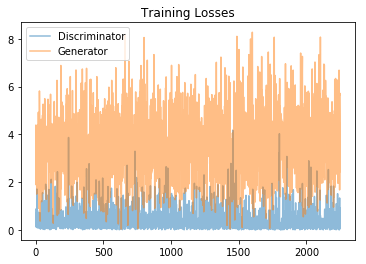

In [82]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [83]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [84]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
    

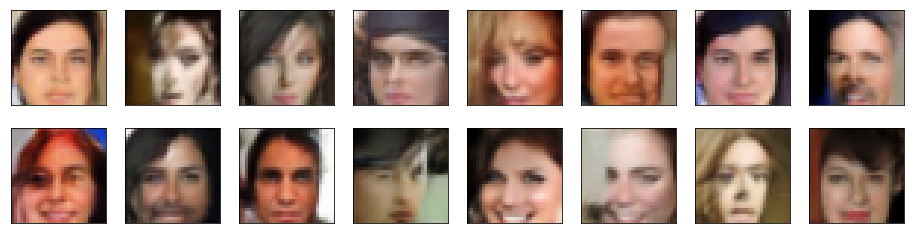

In [88]:
_ = view_samples(-1, samples)


### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


Considering about that the data is biased I can add more samples of celebrity faces that are dark. Some of the features such as eyes and in some cases lips have not been learnt by the network which can be improved by training the network for a long time. the number of epochs can be increased. 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.